# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score
%matplotlib inline

# import the IBM article data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']


# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# identify the number of unique emails in the df dataframe
df.email.nunique()

5148

In [4]:
# count the number of article interactions with each user
df.groupby(df['title'])['email'].count().sort_values(ascending=False)

title
use deep learning for image classification                                            937
insights from new york car accident reports                                           927
visualize car data with brunel                                                        671
use xgboost, scikit-learn & ibm watson machine learning apis                          643
predicting churn with the spss random tree algorithm                                  627
healthcare python streaming application demo                                          614
finding optimal locations of new store using decision optimization                    572
apache spark lab, part 1: basic concepts                                              565
analyze energy consumption in buildings                                               512
gosales transactions for logistic regression model                                    483
welcome to pixiedust                                                                  481
cust

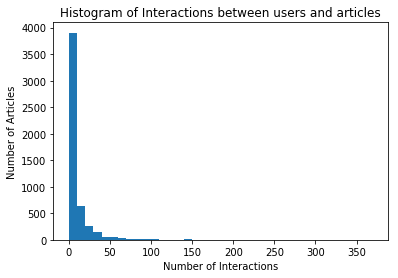

In [5]:
# create histogram of interaction of users with articles
user_article_interactions = df.email.value_counts()

bins = range(0, user_article_interactions.max()+10, 10)
plt.hist(user_article_interactions, bins=bins);
plt.xlabel("Number of Interactions")
plt.ylabel("Number of Articles")
plt.title('Histogram of Interactions between users and articles');


The histogram of interactions between users and articles is right skewed.  Notice that a large number of articles have little to no interaction (almost 4,000).

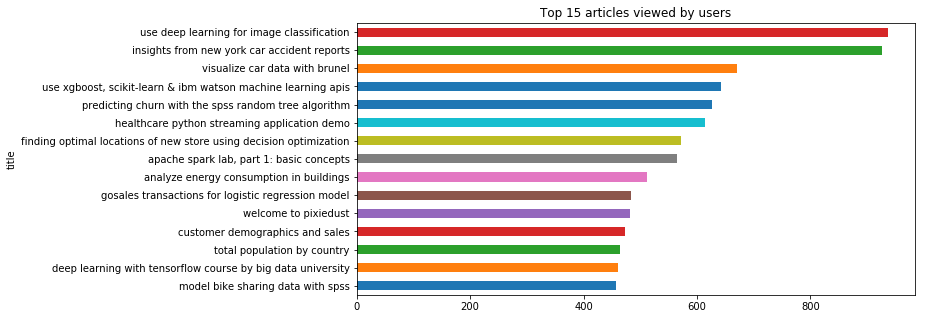

In [6]:
# Create plot of top views by users
email_interactions = df.groupby(df['title'])['email'].count().sort_values(ascending=False).iloc[14: :-1,]\
.plot(kind='barh', figsize=(10,5),
   
title="Top 15 articles viewed by users")
xlabel =("Views by users")
ylabel = ("Title");


The chart above identifies the top 15 articles and the number of interactions.  Notice that the top two articles hade more than 800 interactions.

In [7]:
# determine the shape of the dataframe
df.shape

(45993, 3)

In [8]:
# identiy the number of unique articles
df.article_id.nunique()

714

In [9]:
# identify the median number of articles that a user interacted with an article.
df.groupby(df['email'])['title'].count().median()

3.0

In [10]:
df.email.value_counts().max()

364

In [11]:
# Fill in the median and maximum number of user_article interactios below

median_val = round(df.groupby(df['email'])['title'].count().median(),0)
max_views_by_user = round(df.email.value_counts().max(),0)

print('50% of individuals interact with {} number of articles or fewer.'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# identify the shape of the df_content dataframe
df_content.shape

(1056, 5)

In [13]:
# identify the variables and data types of the df dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [14]:
# identify the variables and data types of the df_content dataframe
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [15]:
# view the contents of the df_content dataframe
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [16]:
# Find and explore duplicate articles
df_content.article_id.value_counts(ascending=False).head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

There are duplicates in the df_content datafrome ( article_id = 221, 232, 577, 398 and 50).  we need to remove the duplicates

In [17]:
# explore the values in the doc_status column
df_content.doc_status.value_counts()

Live    1056
Name: doc_status, dtype: int64

In [18]:
# explore the duplicate data in df_content
id=[221, 232,577,398]
df_content[df_content['article_id'].isin(id)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [19]:
# drop the duplicate rows (keep the first duplicate)
df_content.drop_duplicates(subset ='article_id', keep = 'first', inplace = True) 

In [20]:
# validate the duplicate rows were dropped
df_content.shape

(1051, 5)

In [21]:
# validate the duplicatres were dropped
id=[221, 232,577,398]
df_content[df_content['article_id'].isin(id)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [22]:
joined_data = df.merge(df_content, left_on='article_id', right_on='article_id')
joined_data.head()

,article_id,title,email,doc_body,doc_description,doc_full_name,doc_status
0,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live
1,593.0,upload files to ibm data science experience us...,b6926a8fa3ece411773bfba65c455fb15df4d6c6,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live
2,593.0,upload files to ibm data science experience us...,3c67c75430392122d80ea00ceb313841d4a35c16,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live
3,593.0,upload files to ibm data science experience us...,61f2a8f3c0a6335542feed8cc95038c96ed97668,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live
4,593.0,upload files to ibm data science experience us...,3c67c75430392122d80ea00ceb313841d4a35c16,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live


In [23]:
# # The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
# The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()
# The number of unique users
unique_users = df.email.nunique()
# The number of user-article interactions
user_article_interactions = df.article_id.count()
# The most viewed article in the dataset was viewed _____ times.
max_views = df.article_id.value_counts().max()
#The article_id of the most viewed article is ______.
id= df['article_id'].value_counts().head(1).keys().tolist()
most_viewed_article_id = str(id[0])


print('The number of unique articles that have at least one interaction is {}'.format(unique_articles))
print('The number of unique articles on the IBM platform is {}'.format(total_articles))
print('The number of unique users is {}'.format(unique_users))
print('The number of user-article interactions {}'.format(user_article_interactions))
print('The most viewed article in the dataset was viewed {} times.'.format(max_views))
print('The article_id of the most viewed article is {}.'.format(most_viewed_article_id))

The number of unique articles that have at least one interaction is 714
The number of unique articles on the IBM platform is 1051
The number of unique users is 5148
The number of user-article interactions 45993
The most viewed article in the dataset was viewed 937 times.
The article_id of the most viewed article is 1429.0.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
# create function to get the top articles
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(set(df[df['article_id'].isin(get_top_article_ids(n))]['title']))
    
    return top_articles # Return the top article titles from df (not df_content)

# create function to get the top article ids
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().head(n).keys().tolist()
 
    return top_articles # Return the top article ids

In [27]:
# test the functionality to ensure it works
print(get_top_articles(10))
print(get_top_article_ids(10))

['apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model', 'analyze energy consumption in buildings', 'predicting churn with the spss random tree algorithm', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization', 'healthcare python streaming application demo', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'visualize car data with brunel', 'use deep learning for image classification']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [29]:
# test the code to create a matrix of user_id and article_id using unstack
user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
 
user_item=user_item.notnull().astype(int)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item=user_item.notnull().astype(int)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [31]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [32]:
# create a function to find_similar users
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similar_mat = user_item.dot(user_item.loc[user_id].T)
    # sort by similarity
    most_similar_users = similar_mat.sort_values(ascending=False).index.tolist()

    most_similar_users.remove(user_id)

    return most_similar_users

In [33]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [73]:
# this code creates a function to get article names
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    artic_list = ((df[df['article_id'].isin(article_ids)]['title']))
    article_names = list(set(artic_list))
    
    return article_names # Return the article names associated with list of article ids


# this code creates a function to get the articles a user has interacted with.
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    df = user_item[user_item.index == user_id]
    s = df.iloc[0].sort_values(ascending = False)
    ids = s[s == 1].index.tolist()
    article_ids = []
    for i in range(len(ids)):
        article_ids.append(str(ids[i]))
    article_names = get_article_names(article_ids)
    return  article_ids,article_names # return the ids and names


# this code creates a function to get user recommendations for articles
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
   
    # Your code here
    most_similar_users = find_similar_users(user_id, user_item)

    recs = []

    user_seen_articles, article_titles = get_user_articles(user_id, user_item)
    user_seen_articles = set(user_seen_articles)

    for user in most_similar_users:
        if len(recs) < m:
            article_ids = set(get_user_articles(user, user_item)[0])
            recommended_ids = article_ids.difference(user_seen_articles)
            req_recs = m - len(recs)
            recommended_ids = list(recommended_ids)[:req_recs]
            recs.extend(recommended_ids)
            user_seen_articles = user_seen_articles.union(recommended_ids)
            user_seen_articles = list(user_seen_articles)
    
    recs = recs.sort()         
    return recs

In [74]:
user_user_recs(20)

In [36]:
# Check Results
get_article_names(user_user_recs(20, 10)) # Return 10 recommendations for user 1

['deep learning with tensorflow course by big data university',
 'insights from new york car accident reports',
 'learn tensorflow and deep learning together and now!',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'total employment, by economic activity (thousands)',
 'apache spark lab, part 3: machine learning',
 'analyze accident reports on amazon emr spark',
 'ml algorithm != learning machine',
 'airbnb data for analytics: vienna listings',
 'imitation learning in tensorflow (hopper from openai gym)']

In [37]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [38]:
# This code identifies users based on similarity to other users
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # identify the interactions for each userid with articles
    user_interactions = df.groupby(['user_id'])['article_id'].count()

    # compute similarity of each user to the provided user
    n_users = user_item.shape[0]
    
    # convert into columns
    neighbor_id = [uid for uid in range(1, n_users) if uid != user_id]
    similarity = []
    num_interactions = []
    
    # set calculate the dot product for similarity and num_interactions
    for uid in neighbor_id:
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[uid]))
        num_interactions.append(user_interactions.loc[uid])
        
    # create a neighbors dataframe containing neighbor_id, similarity, and number of intreactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': neighbor_id,
        'similarity': similarity,
        'num_interactions': num_interactions
    })
    
    # sort dataframe by similarity
    neighbors_df.sort_values('similarity', ascending=False, inplace=True)
    
   
    return neighbors_df # Return the dataframe specified in the doc_string


# this code creates a function to find articles the user has not seen before and provide
# recommendations based on the most article interactions
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    neighbors = get_top_sorted_users(user_id)
    # capture top neighbors ids
    
    top_neighbors = list(neighbors[:m]['neighbor_id'])
    # set article_ids seen by top-m neighbors
    
    recs = []
    for uid in top_neighbors:
        article_ids = user_item.loc[uid]
        # another way to append to recs
        recs.extend([str(articleid) for articleid in article_ids[article_ids == 1].index])

    # create recommendations of only m length
    recs = list(set(recs[:m]))

    # attach titles to article ids
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))
    
    # return recs and rec names
    return recs, rec_names

In [39]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['981.0', '793.0', '53.0', '1186.0', '495.0', '1053.0', '232.0', '727.0', '1271.0', '89.0']

The top 10 recommendations for user 20 are the following article names:
['introducing streams designer', 'from python nested lists to multidimensional numpy arrays', 'top 10 machine learning algorithms for beginners', 'access mysql with python', 'customer demographics and sales', '10 powerful features on watson data platform, no coding necessary', 'connect to db2 warehouse on cloud and db2 using scala', 'super fast string matching in python', 'top 20 r machine learning and data science packages', 'self-service data preparation with ibm data refinery']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [40]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0,0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9,0]# Find the 10th most similar user to user 131

In [41]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

 #### Question:  If we were given a new user, which of the above functions would you be able to use to make recommendations? 
 
 We could use the list of top articles for a new user to use.  The function is get_top_article_ids.
 
 #### Can you think of a better way we might make recommendations? 
  
The methodology above uses Collaborative Filtering to make recommendations.  This depends on knowing what movies a user likes.  We would need to use ranking and content based filtering to provide recommendations to new individuals.  That is why I proposed being able to use the get_top_article_ids function.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [42]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str,get_top_article_ids(10)))  # Your recommendations here

    



In [43]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [44]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [45]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [46]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [47]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [48]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [49]:
print('u shape is {} , s shape is {}and vt shape is {}'.format(u.shape, s.shape, vt.shape))

u shape is (5149, 5149) , s shape is (714,)and vt shape is (714, 714)


#### Question - Why is this situation different than what occurred when using SVD in the lesson?

There are two things that I see as differences.  First, we were able to successfully use SVD since there were no null values.  In the lesson, we found that even one NaN in the matrix would prevent us from using SVD.  Second, our example focused on a 4X4 matrix of features that would explain a lot of the variance.  In this example, we are using all of the matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

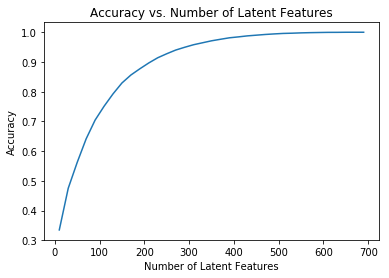

In [50]:
# identify the number of latent features to use in the graph
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

#loop through the latent features
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [51]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [52]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    # create user_item_train, using df_train as the size
    user_item_train = create_user_item_matrix(df_train)
    
    # create user_item_test, using df_test as the size
    user_item_test = create_user_item_matrix(df_test)
    
    # create test_itx
    test_idx = user_item_test.index
    
    # create test_arts column list
    test_arts = user_item_test.columns.values
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [53]:
# this code prints out the answers to the questions in number 4 above
print('We can make predictions for {} users in the test set'\
      .format(user_item_train.index.isin(test_idx).sum()))
print('There are {} users in the test set are we not able to make predictions for because of\
the cold start problem.'\
      .format(len(test_idx) - user_item_train.index.isin(test_idx).sum()))
print('We can make {} movie predictions for the test set'\
      .format(user_item_train.columns.isin(test_arts).sum()))
print('There were {} movies in the test set we are not able to make predictions for\
because of the cold start problem'\
      .format(len(test_arts) - user_item_train.columns.isin(test_arts).sum()))

We can make predictions for 20 users in the test set
There are 662 users in the test set are we not able to make predictions for because ofthe cold start problem.
We can make 574 movie predictions for the test set
There were 0 movies in the test set we are not able to make predictions forbecause of the cold start problem


In [54]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b,  # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [55]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [56]:
# this code prinits the shape of U, S, and VT
print('U shape is {} , S shape is {}and VT shape is {}'.format(u.shape, s.shape, vt.shape))

U shape is (5149, 5149) , S shape is (714,)and VT shape is (714, 714)


In [57]:
#  Fit u, s and vt usnig svd on the user_item_train matrix
u_test, s_test, vt_test =  np.linalg.svd(user_item_train)
print(s_test.shape, u_test.shape, vt_test.shape)
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]
#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]
# Test data
train_idx = user_item_train.index
row_idxs_test = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_test]

(714,) (4487, 4487) (714, 714)


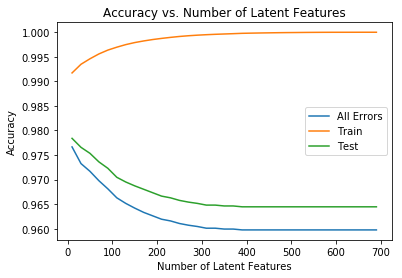

In [58]:
# this code was suggested by Survesh C (Udacity) to plot train, test and errors
latent_feats = np.arange(10, 700+10, 20)
all_errs, train_errs, test_errs = [], [], []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(sub_user_item_test)))/(sub_user_item_test.shape[0]*sub_user_item_test.shape[1])))
    # compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))
    

plt.figure()
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()



`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

###  Conclusion

I did not build the content based recommender.  Based on the data, we had only 20 users twho did not have interactions with any of the IBM articles.  As we can see in the graph above, the accuracy of our predictions (shown as the green test line) seems to decrease as the number of latent factors increases, while the training accuracy increased with an increase in the number of latent features.  

As we recall, looking at the data, 662 users had no interaction with the data (cold start problem).  This means we might not want to rely on accuracy scores.  This is likely due to overfitting and class imbalance.  We have a lot of 0s and few 1s.

Future improvements:

1) We made predictions for only 20 users and 574 articles.  We might want to wait to obtain more date before testing on such a small subset.  We could also use resampling techniques to create a more balanced test and train groups.

2) Enhance this recommendation engine by developing a content based recommender to address cold start users.

3) Use machine learning to categorize articles and allow the user to enter key words as filters

4) Spend additional time determining what is the most appropriate number of latent features to use to avoid overfitting.

A/B Testing To Evaluate Potential Improvement Of Recommendation Engine

Once the recommendation engine is updated, we can split the users into groups, using cookies to keep track of groups and to determine which version of the engine the user interacts with.   Use A/B testing to determine if there is a statistically significant and financially meaningful difference between the control and experimental groups.  

If the result is significant and makes business sense, provide proof to leadership to make the proposed change in the recommendation engine.



In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0